### You are required to code as per the given section and answers the questions inline with the relevant implementation.

# 1. Import the required libraries

In [1]:
##---------Type the code below this line------------------##
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import gensim
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import spacy
from spacy import displacy


C:\ProgramData\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


# 2. Data Understanding

This is the Amazon Fine food review dataset. Each record consists of the following attributes: 

- Id
- ProductId — Unique identifier for the product
- UserId — Unqiue identifier for the user
- ProfileName
- HelpfulnessNumerator — Number of users who found the review helpful
- HelpfulnessDenominator — Number of users who indicated whether they found the review helpful or not
- Score — Rating between 1 and 5
- Time — Timestamp for the review
- Summary — Brief summary of the review
- Text — Text of the review


In [2]:
##---------Type the code below this line------------------##
reviews = pd.read_csv('./Reviews.csv')

print('No. of Reviews:', reviews.shape[0])
#Check the first few lines of the data
reviews.head()

No. of Reviews: 10000


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 3. Data Preparation 

Perform EDA and necessary pre-processing steps in dataset.

Apply pre-processing techiniques

* Removing Punctuations 
* Numbers
* Special Characters
* Stop Words


In [3]:
##---------Type the code below this line------------------##
# Get the original review texts and convert them to lower case
texts = reviews['Text'].str.lower()

#Remove HTML tags
texts = texts.apply(lambda raw_text: BeautifulSoup(raw_text, "lxml").text)

# Remove the punctuations and special characters from the texts
texts = texts.str.replace(r'[^\w\s]', '', regex=True)

#Replace _ with a space to separate the words
texts = texts.str.replace('[_]', ' ', regex=True)

# Remove numbers from the texts
texts = texts.str.replace('[0-9]', '', regex=True)

# Remove the stopwords
stopw = stopwords.words('english') #English stop words from NLTK

texts = texts.apply(lambda x: ' '.join([word for word in x.split() if word not in stopw]))

#Check the tweets now
texts.head()

C:\Users\Biman\AppData\Local\Temp\ipykernel_17712\1660263816.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  texts = texts.apply(lambda raw_text: BeautifulSoup(raw_text, "lxml").text)


0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanutsth...
2    confection around centuries light pillowy citr...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

In [4]:
# Define a function for lemmatization of string 

def my_lemma(text):
    w_list = text.split()
    lemma_text = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for w in w_list:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
        lemma_text.append(word3)
        
    # Combine all of them into a single string
    text = ' '.join(lemma_text)
    return text

#Apply the function to all review texts
texts = texts.apply(lambda text: my_lemma(text))

#Check the dataframe now
texts.head()

0    buy several vitality can dog food product find...
1    product arrive label jumbo salt peanutsthe pea...
2    confection around century light pillowy citrus...
3    look secret ingredient robitussin believe find...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

## 3.1 Wordcloud of the Review Texts

C:\Users\Biman\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


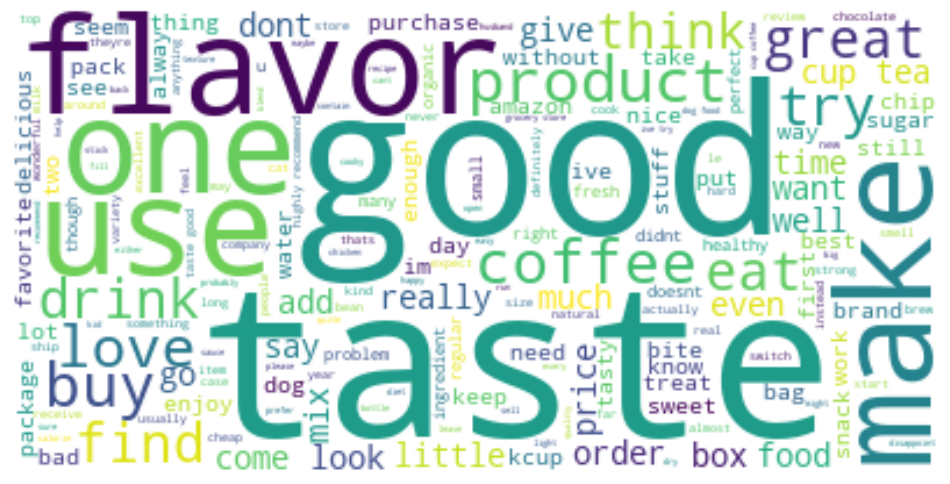

In [5]:
#Join all tweets into one string for wordcloud
all_texts =' '.join(text for text in texts)
all_texts = all_texts.strip()

# Generate the wordcloud - avoid collocations
wc = WordCloud(background_color="white").generate(all_texts)

#Plot the wordcloud
plt.figure( figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3.2 Plot the Bigrams and Trigrams of the Review Texts

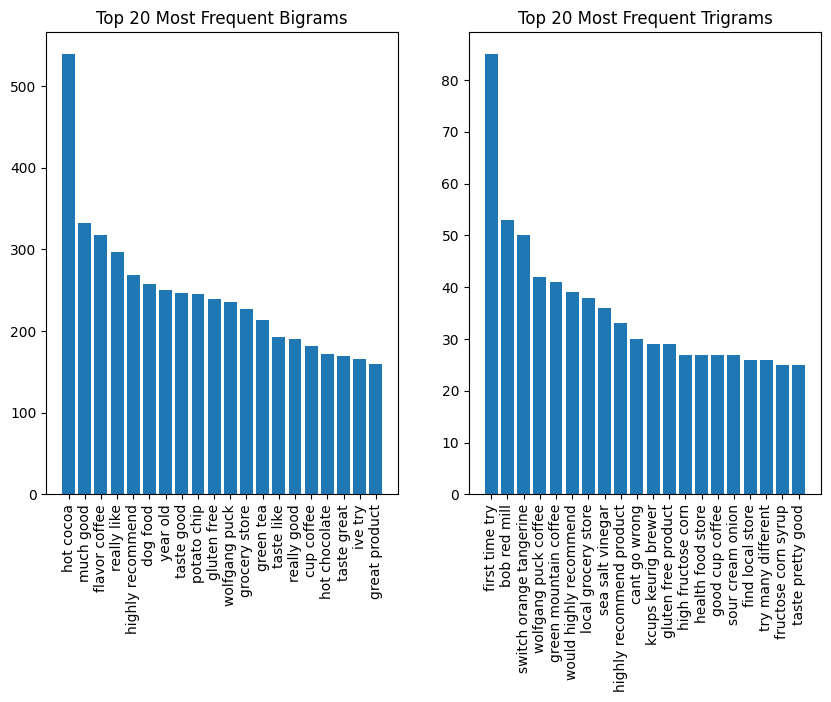

In [6]:
#Get the Top 20 bigrams
#Extract the bigrams
vec = CountVectorizer(ngram_range=(2,2), max_features=20).fit(texts)

#Create a bag of words with bigrams
bag_of_words = vec.transform(texts)

# Compute the frequencies of the bigrams
sum_words = np.asarray(bag_of_words.sum(axis=0)).flatten()
word_freq=dict(zip(vec.vocabulary_.keys(), sum_words))
word_freq=dict(sorted(word_freq.items(), key = lambda x: x[1], reverse=True))

#Plot the bigrams
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.bar(word_freq.keys(), word_freq.values())
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Bigrams')

#Get the Top 20 Trigrams
#Extract the trigrams
vec = CountVectorizer(ngram_range=(3,3), max_features=20).fit(texts)

#Create a bag of words with bigrams
bag_of_words = vec.transform(texts)

# Compute the frequencies of the bigrams
sum_words = np.asarray(bag_of_words.sum(axis=0)).flatten()
word_freq=dict(zip(vec.vocabulary_.keys(), sum_words))
word_freq=dict(sorted(word_freq.items(), key = lambda x: x[1], reverse=True))

#Plot the bigrams
plt.subplot(1,2,2)
plt.bar(word_freq.keys(), word_freq.values())
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Trigrams')
plt.show()

# 4. Using the LDA algorithm create the Topics (Min 10) for the Corpus

NOTE: Use Text Column

In [7]:
##---------Type the code below this line------------------##
#Create the corpus
texts_corpus = [[word for word in text.split()] for text in texts]

# Create Dictionary
id2word = corpora.Dictionary(texts_corpus)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts_corpus]

In [8]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# 5. Compute the coherence score and print Topics Extracted

In [9]:
##---------Type the code below this line------------------##
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

[(0,
  '0.029*"taste" + 0.027*"drink" + 0.027*"sugar" + 0.026*"juice" + '
  '0.020*"like" + 0.018*"orange" + 0.017*"soda" + 0.017*"flavor" + '
  '0.013*"good" + 0.011*"fruit"'),
 (1,
  '0.043*"seed" + 0.025*"chia" + 0.020*"milk" + 0.020*"add" + 0.016*"oil" + '
  '0.014*"use" + 0.013*"protein" + 0.011*"make" + 0.010*"soup" + 0.008*"goat"'),
 (2,
  '0.038*"bag" + 0.022*"chip" + 0.020*"flavor" + 0.014*"good" + 0.012*"like" + '
  '0.012*"salt" + 0.012*"great" + 0.012*"snack" + 0.010*"taste" + '
  '0.009*"pack"'),
 (3,
  '0.041*"product" + 0.027*"price" + 0.024*"amazon" + 0.024*"find" + '
  '0.022*"store" + 0.022*"buy" + 0.022*"good" + 0.021*"great" + 0.017*"order" '
  '+ 0.013*"love"'),
 (4,
  '0.067*"coffee" + 0.024*"flavor" + 0.023*"cup" + 0.020*"taste" + '
  '0.018*"good" + 0.017*"like" + 0.015*"chocolate" + 0.014*"try" + 0.011*"one" '
  '+ 0.009*"roast"'),
 (5,
  '0.031*"food" + 0.018*"dog" + 0.017*"love" + 0.016*"eat" + 0.013*"cat" + '
  '0.011*"like" + 0.011*"one" + 0.009*"organic" +

# 6. Visualize the Topics

In [10]:
##---------Type the code below this line------------------##
# Visualize the topics
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, corpus, id2word, n_jobs=1)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.015498 -0.088418       1        1  19.316626
4      0.092279 -0.108294       2        1  14.876160
5      0.035342 -0.056410       3        1  13.911406
3     -0.115244 -0.102642       4        1   9.711459
8      0.094354  0.019365       5        1   9.423993
6      0.102409  0.018265       6        1   9.224080
0      0.127144  0.042564       7        1   8.810128
2      0.004920 -0.044012       8        1   7.235793
1     -0.010692  0.297606       9        1   4.784514
9     -0.315015  0.021976      10        1   2.705840, topic_info=         Term         Freq        Total Category  logprob  loglift
418    coffee  3811.000000  3811.000000  Default  30.0000  30.0000
1007      tea  1652.000000  1652.000000  Default  29.0000  29.0000
95        bag  1270.000000  1270.000000  Default  28.0000  28.0000
6        food  1858.000000  1858.000000  Default  27.0000  27.0000
817     drink  1710.000000  1710.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
118       two    44.327096   724.798412  Topic10  -5.4487   0.8155
210       use    48.874622  2928.544234  Topic10  -5.3510  -0.4832
1831  plastic    35.488063   202.099617  Topic10  -5.6711   1.8702
191       one    39.398606  3027.770159  Topic10  -5.5665  -0.7321
276      time    36.401969  1635.543578  Topic10  -5.6456  -0.1953

[748 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4297      7  0.974299  acerola
8277      2  0.973563   acidic
6553      1  0.962424  acidity
448       1  0.026134      add
448       2  0.020418      add
...     ...       ...      ...
3249      9  0.967557   yogurt
7906      2  0.982755    yuban
1617      2  0.201296      yum
1617      8  0.771634      yum
5227      1  0.981820    zukes

[1934 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 6, 4, 9, 7, 1, 3, 2, 10])

# 7. Plot Dependency Parser

Plot the dependency parser for any two random sentences from the entire corpus/dataset that has at least 10 words in the sentence. Make sure that dependency parser looks good and should visually understandable.

In [11]:
#!python -m spacy download en_core_web_sm

In [16]:
##---------Type the code below this line------------------##


nlp = spacy.load('en_core_web_sm')

np.random.seed(42)

for i in range(2):
    word_count = 0
    while word_count < 10:
        id = np.random.randint(0, reviews.shape[0])
        sentences = nltk.sent_tokenize(reviews['Text'][id])
        for sentence in sentences:
            word_count = len([word for word in sentence.split()])
            if word_count >= 10:
                doc = nlp(sentence)
                print(sentence)
                displacy.render(doc, style='dep', jupyter=True)
                break

This is the wondeful white popcorn we ate in Iowa years ago!


C:\ProgramData\anaconda3\lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


The chocolate on the stick was all melted and all the sticks were stuck with oneanother.


C:\ProgramData\anaconda3\lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display
